# Import

In [0]:
!pip install pmdarima

     |████████████████████████████████| 2.1 MB 18.4 MB/s 
     |██▍           

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 16.8 MB 78.4 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 233 kB 85.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-ade92dc5-d530-4d2e-9023-3209449e8bb6
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.2
    Not uninstalling patsy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-ade92dc5-d530-4d2e-9023-3209449e8bb6
    Can't uninstall 'patsy'. No files were found to uninstall.
  Attempting uninstall: packaging
    Found existin

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import pandas as pd
import numpy as np 
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)
spark = SparkSession.builder.getOrCreate()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
new_companies_trend_df = pd.read_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/new_companies_trend-1.csv")
old_companies_trend_df = pd.read_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/old_companies_trend-2.csv")

# General Preprocess

In [0]:
def extract_dates_and_values(s):
    if isinstance(s, str):
        dates = re.findall(r'\w{3} \d{1,2}, \d{4}', s)
        scores = re.findall(r'\d+(?=[\u202a\u202c][A-Za-z]{3} \d+,)', s)
        if dates == [] or scores == []:
            return None, None
        return dates[:-1], scores[1:]
    else:
        return None, None

old_companies_trend_df['name'] = old_companies_trend_df['input_url'].apply(lambda url: url.split('q=')[-1])
old_companies_trend_df[['dates', 'scores']] = old_companies_trend_df['table'].apply(lambda x: pd.Series(extract_dates_and_values(x)))
old_companies_trend_df = old_companies_trend_df[['name', 'dates', 'scores']]

new_companies_trend_df['name'] = new_companies_trend_df['input_url'].apply(lambda url: url.split('q=')[-1])
new_companies_trend_df[['dates', 'scores']] = new_companies_trend_df['table'].apply(lambda x: pd.Series(extract_dates_and_values(x)))
new_companies_trend_df = new_companies_trend_df[['name', 'dates', 'scores']]

In [0]:
print('number of records that return without data for the old companies: ', old_companies_trend_df.shape[0] - old_companies_trend_df.dropna().shape[0])
print('number of records that return without data for the new companies: ', new_companies_trend_df.shape[0] - new_companies_trend_df.dropna().shape[0])

old_companies_trend_df = old_companies_trend_df.dropna()
new_companies_trend_df = new_companies_trend_df.dropna()
old_companies_trend_df = old_companies_trend_df.drop_duplicates(subset='name')
new_companies_trend_df = new_companies_trend_df.drop_duplicates(subset='name')

number of records that return without data for the old companies:  3577
number of records that return without data for the new companies:  429


In [0]:
# old companies

old_companies_trend_df['scores'] = old_companies_trend_df['scores'].apply(lambda x: (np.array(x).astype(int)))
# remove 0 values from the begining of the time series
old_companies_trend_df['index_to_drop'] = old_companies_trend_df['scores'].apply(lambda x: np.where(x != 0)[0][0] if len(np.where(x != 0)[0]) > 0 else 0)
old_companies_trend_df['scores'] = old_companies_trend_df.apply(lambda row: row['scores'][row['index_to_drop']:], axis=1)
old_companies_trend_df['dates'] = old_companies_trend_df.apply(lambda row: row['dates'][row['index_to_drop']:], axis=1)

# remove records without enough data
old_companies_trend_df = old_companies_trend_df[old_companies_trend_df['scores'].apply(lambda x: len(x) > 51)]
old_companies_trend_df = old_companies_trend_df[old_companies_trend_df['scores'].apply(lambda x: (np.percentile(x, 50) > 0))]

In [0]:
# new companies

new_companies_trend_df['scores'] = new_companies_trend_df['scores'].apply(lambda x: (np.array(x).astype(int)))
# remove 0 values from the begining of the time series
new_companies_trend_df['index_to_drop'] = new_companies_trend_df['scores'].apply(lambda x: np.where(x != 0)[0][0] if len(np.where(x != 0)[0]) > 0 else 0)
new_companies_trend_df['scores'] = new_companies_trend_df.apply(lambda row: row['scores'][row['index_to_drop']:], axis=1)
new_companies_trend_df['dates'] = new_companies_trend_df.apply(lambda row: row['dates'][row['index_to_drop']:], axis=1)

# remove records without enough data
new_companies_trend_df = new_companies_trend_df[new_companies_trend_df['scores'].apply(lambda x: len(x) > 104)]
new_companies_trend_df = new_companies_trend_df[new_companies_trend_df['scores'].apply(lambda x: (np.percentile(x, 50) > 0))]

In [0]:
old_companies_trend_df[['name', 'dates', 'scores']].head(10)

,name,dates,scores
6,Wesley Housing,"[Aug 1, 2004, Sep 1, 2004, Oct 1, 2004, Nov 1,...","[100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
8,One Comm,"[Jan 1, 2013, Feb 1, 2013, Mar 1, 2013, Apr 1,...","[68, 61, 45, 51, 59, 35, 52, 56, 56, 60, 46, 5..."
9,Lorain County JVS,"[Jul 1, 2007, Aug 1, 2007, Sep 1, 2007, Oct 1,...","[92, 90, 0, 0, 0, 100, 0, 0, 0, 94, 76, 0, 0, ..."
13,JR Butler,"[Feb 1, 2005, Mar 1, 2005, Apr 1, 2005, May 1,...","[27, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 14, 0, 0, ..."
14,INSTALL,"[Jan 1, 2004, Feb 1, 2004, Mar 1, 2004, Apr 1,...","[99, 93, 93, 90, 86, 92, 94, 100, 97, 96, 91, ..."
15,Westside Community Schools,"[Dec 1, 2005, Jan 1, 2006, Feb 1, 2006, Mar 1,...","[100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, ..."
19,K&L Microwave,"[Jan 1, 2004, Feb 1, 2004, Mar 1, 2004, Apr 1,...","[60, 58, 59, 61, 59, 59, 61, 60, 61, 60, 62, 6..."
20,Insight Meditation Society,"[Jun 1, 2004, Jul 1, 2004, Aug 1, 2004, Sep 1,...","[100, 67, 0, 0, 68, 70, 50, 0, 0, 49, 0, 0, 0,..."
22,Downstream,"[Jan 1, 2017, Feb 1, 2017, Mar 1, 2017, Apr 1,...","[54, 61, 60, 61, 63, 61, 59, 56, 61, 65, 61, 5..."
28,Smith Engineering,"[Jan 1, 2010, Feb 1, 2010, Mar 1, 2010, Apr 1,...","[91, 96, 86, 100, 79, 94, 88, 71, 88, 87, 72, ..."


In [0]:
new_companies_trend_df[['name', 'dates', 'scores']].head(10)

,name,dates,scores
0,30 Friends,"[Dec 29, 2019, Jan 5, 2020, Jan 12, 2020, Jan ...","[56, 45, 45, 48, 48, 38, 46, 52, 54, 43, 33, 3..."
4,OFFSET,"[Dec 29, 2019, Jan 5, 2020, Jan 12, 2020, Jan ...","[26, 27, 29, 28, 34, 31, 30, 34, 35, 33, 30, 2..."
7,Small Business Tips,"[Dec 29, 2019, Jan 5, 2020, Jan 12, 2020, Jan ...","[38, 40, 35, 30, 33, 29, 25, 27, 40, 29, 31, 6..."
9,Pindustry,"[Mar 28, 2021, Apr 4, 2021, Apr 11, 2021, Apr ...","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 20, 76, ..."
23,Ampere EV,"[Feb 16, 2020, Feb 23, 2020, Mar 1, 2020, Mar ...","[25, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3..."
24,Workshop,"[Dec 27, 2020, Jan 3, 2021, Jan 10, 2021, Jan ...","[60, 65, 64, 66, 67, 66, 65, 67, 68, 66, 65, 6..."
25,Victory Team,"[Dec 29, 2019, Jan 5, 2020, Jan 12, 2020, Jan ...","[32, 45, 41, 48, 55, 41, 35, 36, 49, 29, 41, 1..."
26,Colin & Co.,"[Dec 26, 2021, Jan 2, 2022, Jan 9, 2022, Jan 1...","[76, 71, 69, 67, 68, 70, 80, 97, 62, 85, 100, ..."
39,Origin Story,"[Dec 29, 2019, Jan 5, 2020, Jan 12, 2020, Jan ...","[49, 60, 54, 52, 51, 61, 64, 58, 59, 57, 53, 6..."
50,OOSS,"[Dec 26, 2021, Jan 2, 2022, Jan 9, 2022, Jan 1...","[50, 44, 69, 64, 42, 54, 60, 0, 52, 51, 57, 46..."


In [0]:
def plot_company_trend(companies,company_name, plot_moving_std=False, plot_moving_mean=False, plot_forecast=False):
    dates = list(companies[companies['name'] == company_name]['dates'])[0]
    scores = list(companies[companies['name'] == company_name]['scores'])[0]
    if not plot_forecast:
        moving_std = list(companies[companies['name'] == company_name]['12_month_moving_std'])[0]
        moving_mean = list(companies[companies['name'] == company_name]['12_month_moving_mean'])[0]
        data = list(zip(dates, scores, moving_std, moving_mean))
        df = pd.DataFrame(data, columns=['dates', 'scores', 'moving_std', 'moving_mean'])
    else:
        data = list(zip(dates, scores))
        df = pd.DataFrame(data, columns=['dates', 'scores'])
    
    df['dates'] = pd.to_datetime(df['dates'])

    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", 8)
    plt.figure(figsize=(15, 6)) 
    sns.lineplot(data=df, x='dates', y='scores', linewidth=2, label='Company Trend', color=palette[5])
    if plot_moving_std:
        sns.lineplot(data=df, x='dates', y='moving_std', linewidth=2, label='12 Month Moving Std', color=palette[6])
    if plot_moving_mean:
        sns.lineplot(data=df, x='dates', y='moving_mean', linewidth=2, label='12 Month Moving Mean', color=palette[7])
    if plot_forecast:
        time_series = pd.Series(data=scores, index=dates)
        decomposition = seasonal_decompose(time_series, model='additive', extrapolate_trend='freq')
        trend = decomposition.trend
        model_fit_auto = auto_arima(trend.dropna(), seasonal=True)
        FORECAST = 26
        next12m = model_fit_auto.predict(n_periods=FORECAST)
        next12m = next12m.where(next12m <= 100, 100)
        sns.lineplot(data=trend, linewidth=2, label='Seasonal Decomposition Trend', color=palette[2])
        sns.lineplot(data=next12m,linewidth=2, label=f'Forecast', color=palette[3])

    plt.ylim(0,100)
    plt.xlabel('Date')
    plt.ylabel('Trend Score')
    plt.title(f'{company_name} Company')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Stability

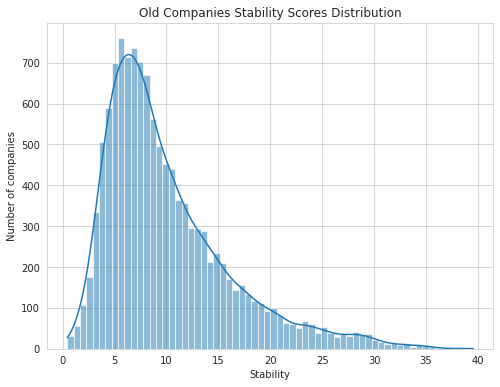

In [0]:
# old companies stability score
old_companies_trend_df['12_month_moving_std'] = old_companies_trend_df['scores'].apply(lambda x: np.array(pd.Series(x).rolling(window=12).std().dropna()))
old_companies_trend_df['stability'] = old_companies_trend_df['12_month_moving_std'].apply(lambda x: np.nanpercentile(x, 75))

plt.figure(figsize=(8, 6)) 
sns.histplot(data=old_companies_trend_df, x='stability', kde=True)
plt.title('Old Companies Stability Scores Distribution')
plt.xlabel('Stability')
plt.ylabel('Number of companies')
plt.show()


In [0]:
# Example of high stability 
plot_company_trend(old_companies_trend_df,'Scholastic', plot_moving_std=True)

# Example of low stability
plot_company_trend(old_companies_trend_df,'Communications', plot_moving_std=True)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
/databricks/python/lib/python3.9/site-packages/pandas/core/indexes/base.py in get_loc(self, key, method, tolerance)
   3360             try:
-> 3361                 return self._engine.get_loc(casted_key)
   3362             except KeyError as err:

/databricks/python/lib/python3.9/site-packages/pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

/databricks/python/lib/python3.9/site-packages/pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: '12_month_moving_mean'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call la

# Popularity

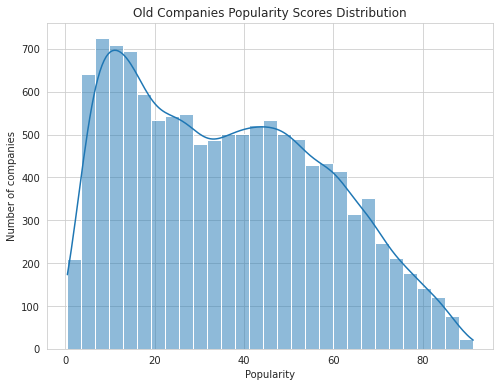

In [0]:
# old companies popularity score
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def compute_popularity_score(scores_list):
    total_scores = len(scores_list)
    weights = np.array([(i**(1/3)) for i in range(total_scores)])
    weights = softmax(weights)
    popularity_score = np.sum(np.array(scores_list) * weights)
    return popularity_score

old_companies_trend_df['12_month_moving_mean'] = old_companies_trend_df['scores'].apply(lambda x: np.array(pd.Series(x).rolling(window=12).mean().dropna()))
old_companies_trend_df['popularity'] = old_companies_trend_df['scores'].apply(compute_popularity_score)

plt.figure(figsize=(8, 6)) 
sns.histplot(data=old_companies_trend_df, x='popularity', kde=True)
plt.title('Old Companies Popularity Scores Distribution')
plt.xlabel('Popularity')
plt.ylabel('Number of companies')
plt.show()

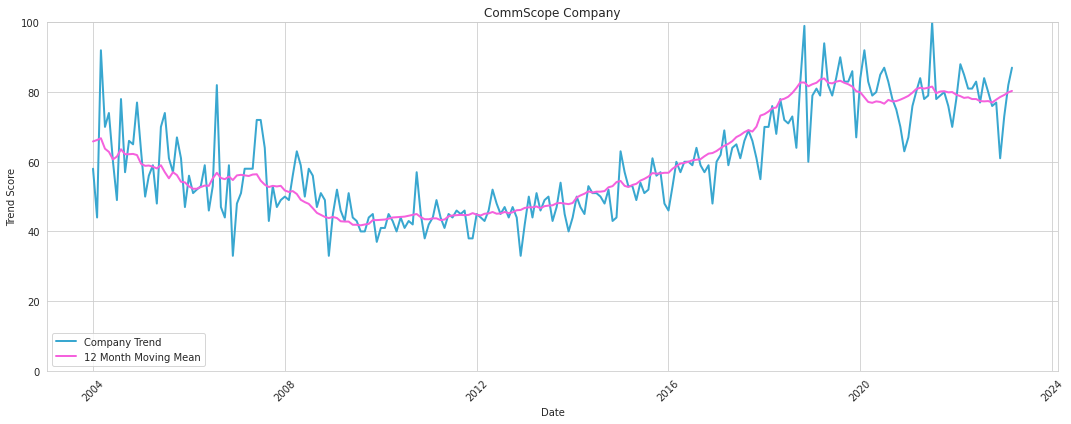

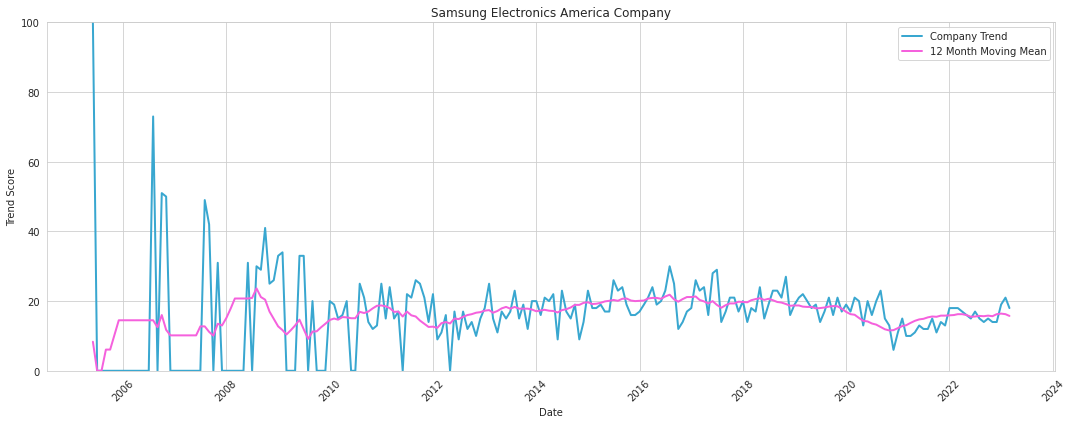

In [0]:
# Example of high popularity 
plot_company_trend(old_companies_trend_df,'CommScope', plot_moving_mean=True)

# Example of low populariy
plot_company_trend(old_companies_trend_df,'Samsung Electronics America', plot_moving_mean=True)

# Growth

In [0]:
# growth score
def growth_score(scores, dates):
    time_series = pd.Series(data=scores, index=dates)
    decomposition = seasonal_decompose(time_series, model='additive', extrapolate_trend='freq')
    trend = decomposition.trend
    model_fit_auto = auto_arima(trend.dropna(), seasonal=True)
    FORECAST = 26
    next12m = model_fit_auto.predict(n_periods=FORECAST)
    next12m = next12m.where(next12m <= 100, 100)
    return (next12m.iloc[-1] - next12m.iloc[0]) / FORECAST

new_companies_trend_df['dates'] = new_companies_trend_df['dates'].apply(lambda x: [pd.to_datetime(date_str, format='%b %d, %Y') for date_str in x])
new_companies_trend_df['growth'] = new_companies_trend_df.apply(lambda x: growth_score(x['scores'], x['dates']), axis=1)

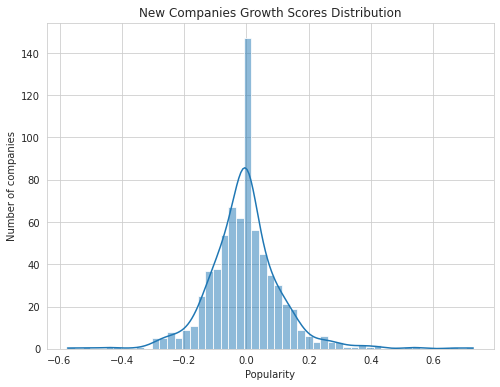

In [0]:
plt.figure(figsize=(8, 6)) 
sns.histplot(data=new_companies_trend_df, x='growth', kde=True)
plt.title('New Companies Growth Scores Distribution')
plt.xlabel('Popularity')
plt.ylabel('Number of companies')
plt.show()

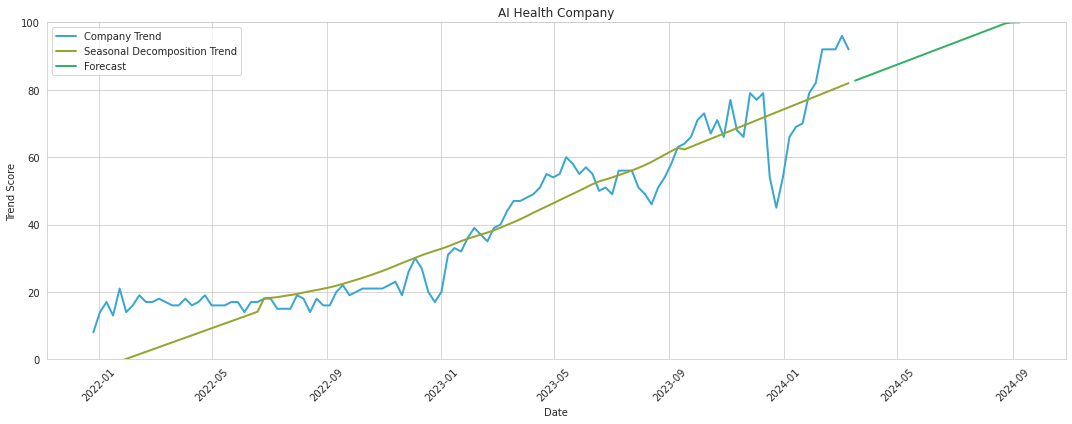

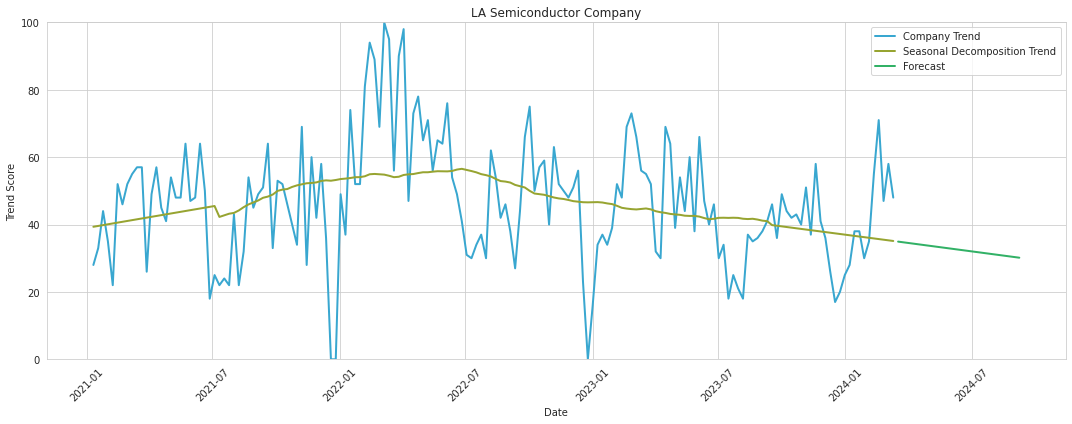

In [0]:
# Example of high growth 
plot_company_trend(new_companies_trend_df, 'AI Health', plot_forecast=True)

# Example of low growth
plot_company_trend(new_companies_trend_df, 'LA Semiconductor', plot_forecast=True)

# Add the "real" name of the company (without preprocess on the name)

In [0]:
companies = spark.read.parquet('/linkedin/companies')

In [0]:
def preprocess_company_names(df):
  df_names = df['name'].to_list()
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words('english'))
  search_name_list = []
  real_name_dict = {}

  for name in df_names:
      real_name = name
      # Remove special characters
      name = re.sub(r'\bInc.\b', '', name).strip()
      name = re.sub(r'\bInc\b', '', name).strip()
      name = re.sub(r'\bCo.\b', '', name).strip()
      name = re.sub(r'[^\w\s.,&()-]', '', name)

      if '-' in name or ',' in name or '(' in name:
        if '-' in name:
          parts = name.split('-')
          name = parts[0].strip()  # Get the part before the hyphen and remove any leading/trailing whitespace

        if ',' in name:
          parts = name.split(',')
          name = parts[0].strip()  # Get the part before the hyphen and remove any leading/trailing whitespace
      
        if '(' in name:
          parts = name.split('(')
          informative_part = parts[-1].strip()  # Get the part before the hyphen and remove any leading/trailing whitespace
          informative_part = informative_part.split(')')[0].strip()
          if informative_part.isupper():
            name = informative_part
          else: 
            name = parts[0].strip()

    #   search_name_list.append(name)
      real_name_dict[name] = real_name

  return real_name_dict

In [0]:
# old companies 
old_companies = companies.filter((col('founded') >= '1900') & (col('founded') < '2020'))
old_companies_df = old_companies.toPandas()

# new companies 
new_companies = companies.filter((col('founded') >= '2020') & (col('founded') < '2025'))
new_companies_df = new_companies.toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field affiliated. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType([StructField('Links', StringType(), True), StructField('location', StringType(), True), StructField('subtitle', StringType(), True), StructField('title', StringType(), True)]), True)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field af

In [0]:
old_real_name_dict = preprocess_company_names(old_companies_df)
old_companies_trend_df = old_companies_trend_df.rename(columns={'name':'search_name'})
old_companies_trend_df['name'] = old_companies_trend_df['search_name'].map(old_real_name_dict)

new_real_name_dict = preprocess_company_names(new_companies_df)
new_companies_trend_df = new_companies_trend_df.rename(columns={'name':'search_name'})
new_companies_trend_df['name'] = new_companies_trend_df['search_name'].map(new_real_name_dict) 

# Save the companies trends

In [0]:
old_companies_trend_df.to_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/final_old_companies_trend_preprocess", header=True)
new_companies_trend_df.to_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/final_new_companies_trend_preprocess", header=True)